In [47]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import ConfusionMatrixDisplay

In [48]:
df = pd.read_csv("stock_risk_prediction_dataset.csv")

In [49]:
df.head()

,current_stock,avg_daily_demand,lead_time_days,reorder_point,sales_last_30_days,stock_turnover_ratio,forecast_error,season,item_category,supplier_reliability,stock_status
0,549,45.76,5.64,342.83,1604.49,4.17,-9.90,peak,essential,low,overstock
1,486,45.47,6.39,348.37,1585.00,4.01,-5.27,peak,non-essential,high,overstock
2,564,32.04,5.81,353.21,1219.04,3.57,-2.94,off-peak,non-essential,high,overstock
3,652,46.70,7.22,397.34,1673.88,4.00,0.75,off-peak,essential,low,overstock
4,476,57.33,9.39,312.64,1052.98,4.49,5.12,peak,essential,high,overstock


In [50]:
#Initial Data Inspection
print("Dataset Shape:", df.shape)
print("\nColumn Data Types:")
print(df.dtypes)
print("\nFirst 5 Rows:")
print(df.head())

Dataset Shape: (5000, 11)

Column Data Types:
current_stock             int64
avg_daily_demand        float64
lead_time_days          float64
reorder_point           float64
sales_last_30_days      float64
stock_turnover_ratio    float64
forecast_error          float64
season                   object
item_category            object
supplier_reliability     object
stock_status             object
dtype: object

First 5 Rows:
   current_stock  avg_daily_demand  lead_time_days  reorder_point  \
0            549             45.76            5.64         342.83   
1            486             45.47            6.39         348.37   
2            564             32.04            5.81         353.21   
3            652             46.70            7.22         397.34   
4            476             57.33            9.39         312.64   

   sales_last_30_days  stock_turnover_ratio  forecast_error    season  \
0             1604.49                  4.17           -9.90      peak   
1           

In [51]:
# Check for Missing Values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
current_stock           0
avg_daily_demand        0
lead_time_days          0
reorder_point           0
sales_last_30_days      0
stock_turnover_ratio    0
forecast_error          0
season                  0
item_category           0
supplier_reliability    0
stock_status            0
dtype: int64


In [52]:
# Summary Statistics
print("\nSummary Statistics (Numerical):")
print(df.describe())


Summary Statistics (Numerical):
       current_stock  avg_daily_demand  lead_time_days  reorder_point  \
count    5000.000000       5000.000000     5000.000000    5000.000000   
mean      500.065800         49.901224        7.021084     350.825734   
std        99.647785         10.104358        1.997617      50.166808   
min       175.000000         10.780000        0.250000     157.180000   
25%       434.000000         43.130000        5.680000     316.765000   
50%       501.000000         49.825000        7.020000     350.960000   
75%       566.000000         56.772500        8.350000     385.332500   
max       892.000000         85.290000       13.860000     573.950000   

       sales_last_30_days  stock_turnover_ratio  forecast_error  
count         5000.000000           5000.000000     5000.000000  
mean          1494.494344              3.993402       -0.054578  
std            295.012442              0.999404        5.129634  
min            403.470000              0.5500

In [53]:
print("\nSummary Statistics (Categorical):")
print(df.describe(include='object'))


Summary Statistics (Categorical):
          season item_category supplier_reliability stock_status
count       5000          5000                 5000         5000
unique         2             2                    2            2
top     off-peak     essential                  low    overstock
freq        2508          2505                 2514         4543


In [54]:
# Standardize Categorical Labels
categorical_cols = ['season', 'item_category', 'supplier_reliability', 'stock_status']
for col in categorical_cols:
    df[col] = df[col].str.lower().str.strip()

In [55]:
# Check Unique Values
for col in categorical_cols:
    print(f"\nUnique values in '{col}':", df[col].unique())


Unique values in 'season': ['peak' 'off-peak']

Unique values in 'item_category': ['essential' 'non-essential']

Unique values in 'supplier_reliability': ['low' 'high']

Unique values in 'stock_status': ['overstock' 'stockout']


In [56]:
# Check for Duplicates
duplicates = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")
if duplicates > 0:
    df = df.drop_duplicates()
    print(f"Duplicates removed. New shape: {df.shape}")


Number of duplicate rows: 0


In [57]:
# Check Target Class Balance
print("\nTarget Class Distribution:")
print(df['stock_status'].value_counts(normalize=True) * 100)


Target Class Distribution:
stock_status
overstock    90.86
stockout      9.14
Name: proportion, dtype: float64


## EDA Process 

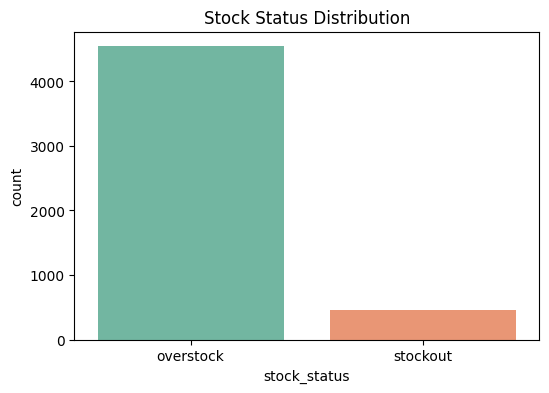

In [58]:
# 1. Class Distribution
# -------------------------------
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='stock_status',hue='stock_status',palette='Set2',legend = False)
plt.title("Stock Status Distribution")
plt.show()

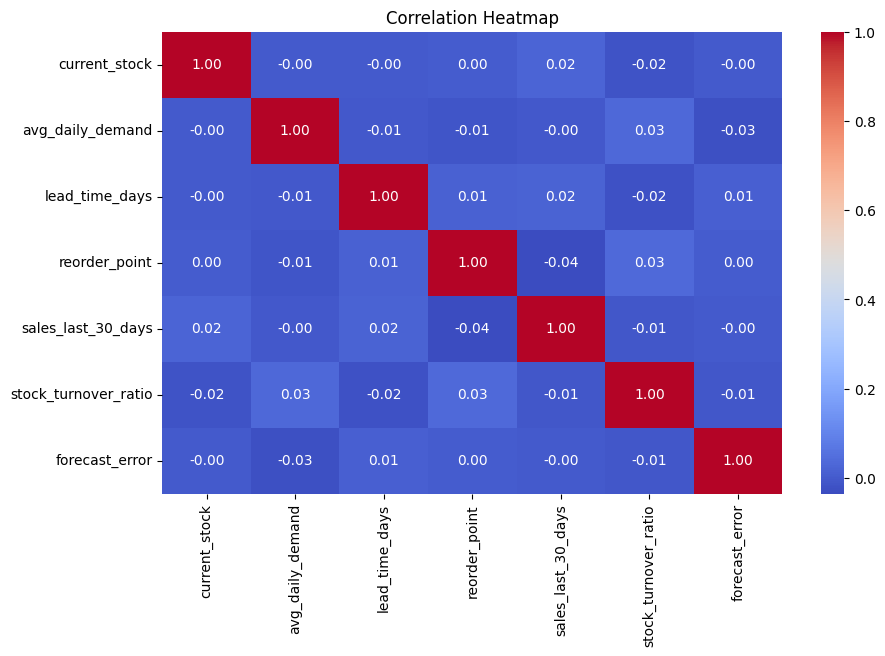

In [59]:
# 2. Correlation Heatmap (Numerical)
plt.figure(figsize=(10, 6))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")

# Create the directory if it doesn't exist
output_dir = "eda_figures"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

plt.savefig(os.path.join(output_dir, "correlation_heatmap.png"))
plt.show()

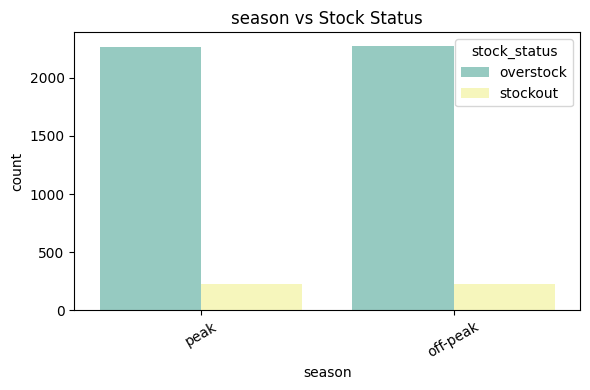

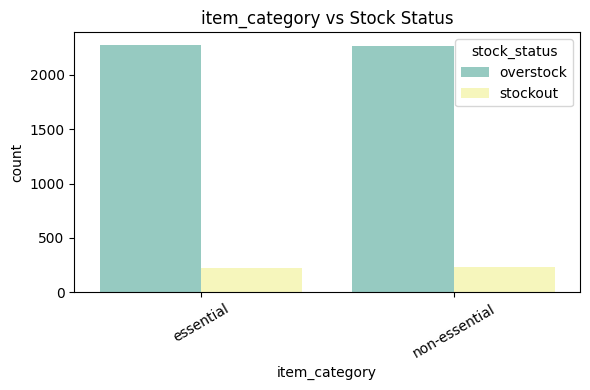

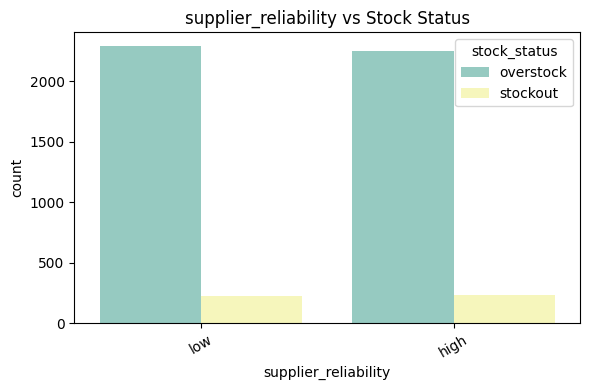

In [60]:
# 3. Categorical vs Stock Status-
categorical_features = ['season', 'item_category', 'supplier_reliability']

for col in categorical_features:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df, x=col, hue='stock_status', palette='Set3')
    plt.title(f"{col} vs Stock Status")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

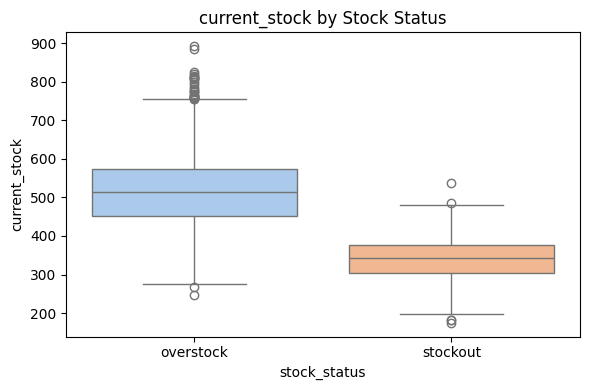

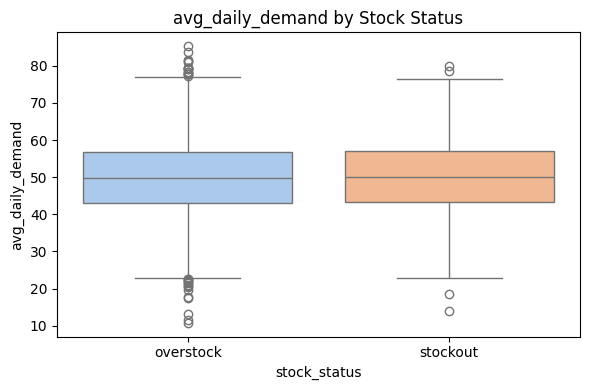

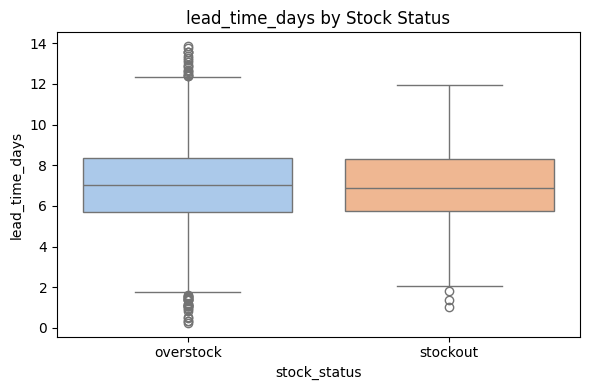

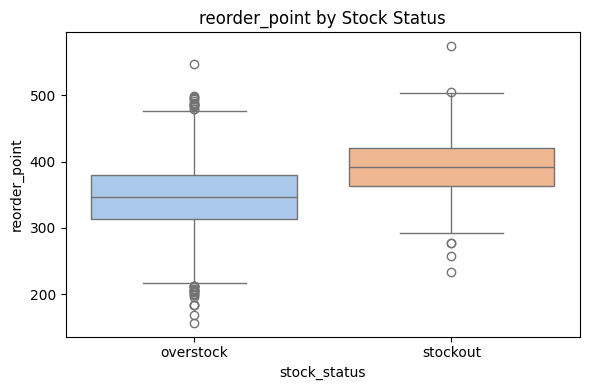

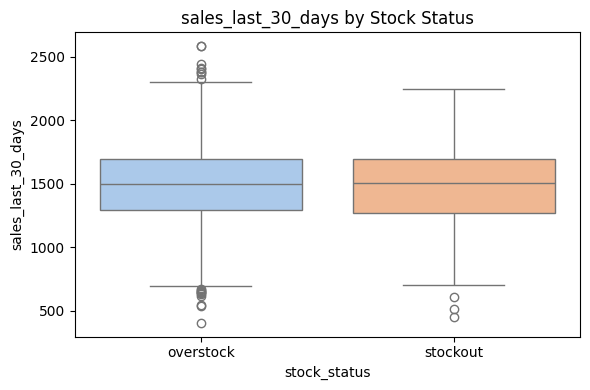

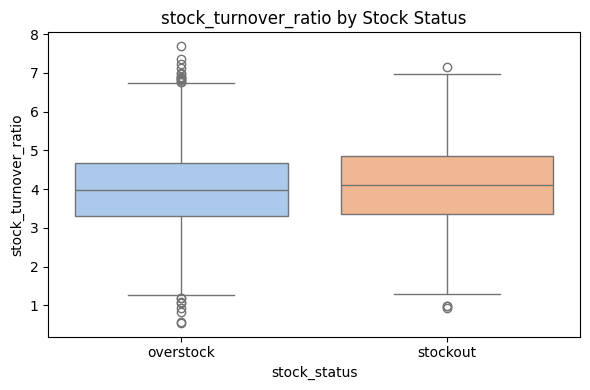

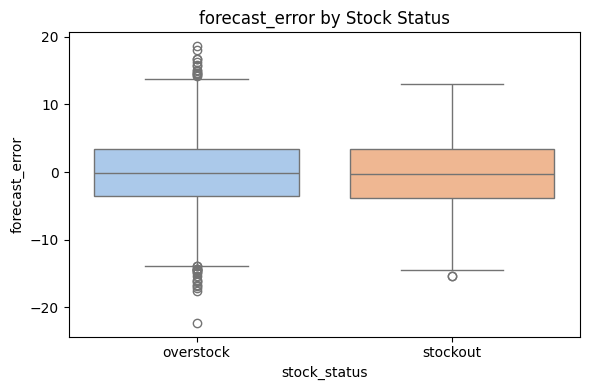

In [61]:
# 4. Numeric Features vs Stock Status

numeric_features = [
    'current_stock', 'avg_daily_demand', 'lead_time_days',
    'reorder_point', 'sales_last_30_days', 'stock_turnover_ratio', 'forecast_error'
]

for feature in numeric_features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df, x='stock_status', y=feature,hue='stock_status', palette='pastel',legend = False)
    plt.title(f"{feature} by Stock Status")
    plt.tight_layout()
    plt.show()

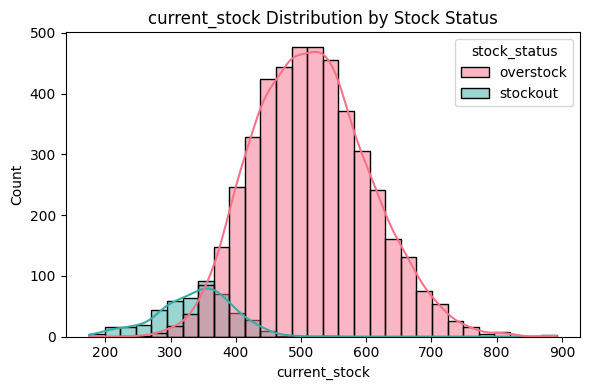

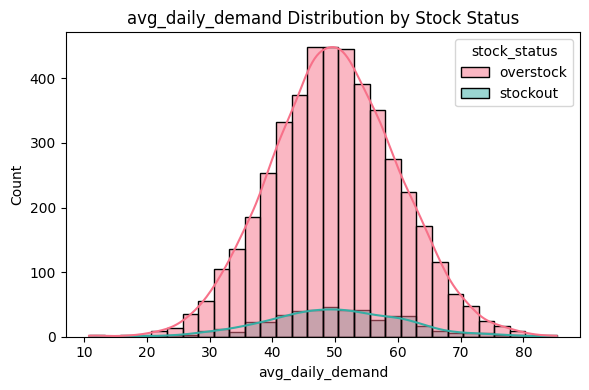

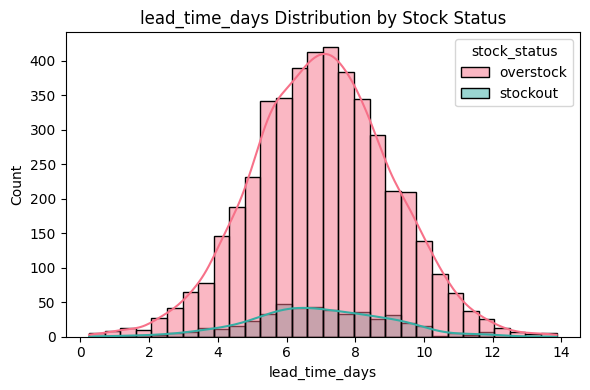

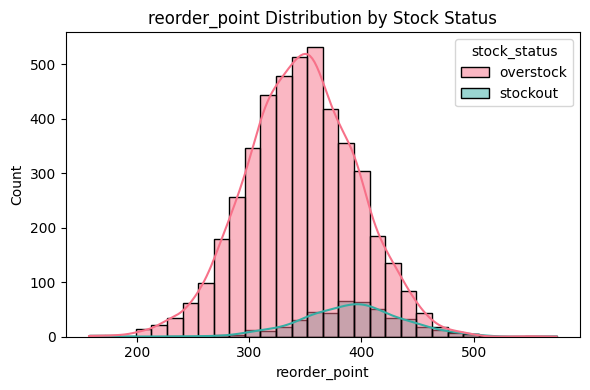

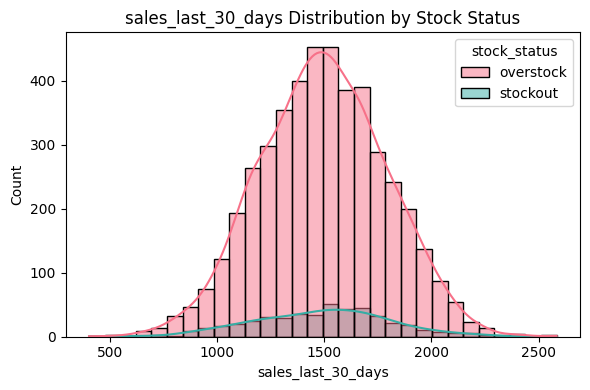

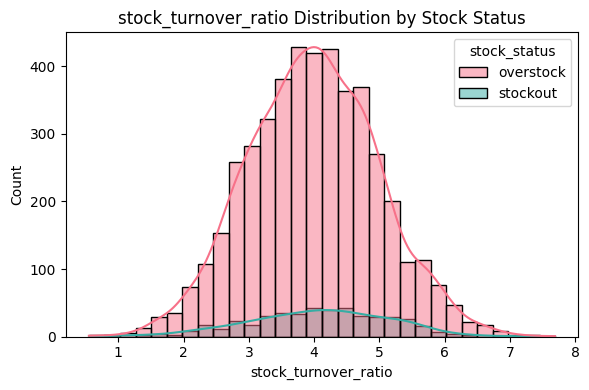

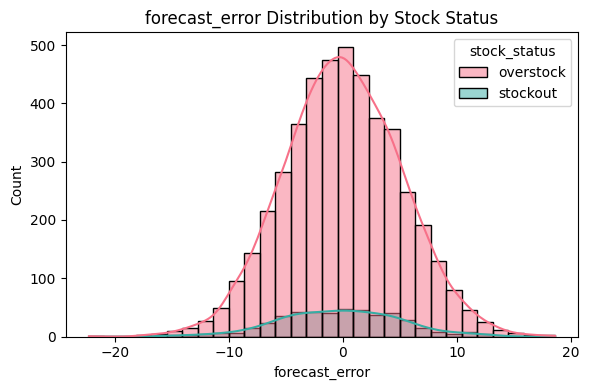

In [62]:
# 5. Distribution Plots

for feature in numeric_features:
    plt.figure(figsize=(6, 4))
    sns.histplot(data=df, x=feature, hue='stock_status', kde=True, bins=30, palette='husl')
    plt.title(f"{feature} Distribution by Stock Status")
    plt.tight_layout()
    plt.show()

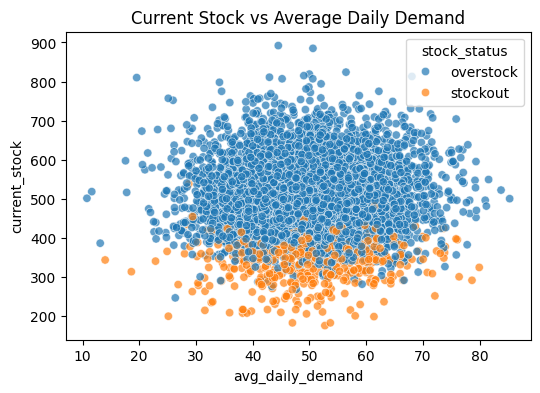

In [63]:
#6 Current Stock vs Average Daily Demand
plt.figure(figsize=(6, 4))
sns.scatterplot(data=df, x='avg_daily_demand', y='current_stock', hue='stock_status', alpha=0.7)
plt.title("Current Stock vs Average Daily Demand")
plt.show()

In [64]:
# Encode categorical variables
df_encoded = df.copy()
label_encoders = {}

In [65]:
categorical_cols = ['season', 'item_category', 'supplier_reliability', 'stock_status']
for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le

In [66]:
# Split features and target
X = df_encoded.drop('stock_status', axis=1)
y = df_encoded['stock_status']

In [67]:
# Split the data before applying SMOTE (to prevent data leakage)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [68]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [69]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

In [70]:
# Display class distribution after SMOTE
print("Original training set class distribution:")
print(y_train.value_counts())

print("\nBalanced training set class distribution:")
print(y_train_bal.value_counts())

Original training set class distribution:
stock_status
0    3634
1     366
Name: count, dtype: int64

Balanced training set class distribution:
stock_status
0    3634
1    3634
Name: count, dtype: int64


# applied SMOTE only on the training set, not the whole dataset.
# proceed to model building using X_train_bal and y_train_bal.

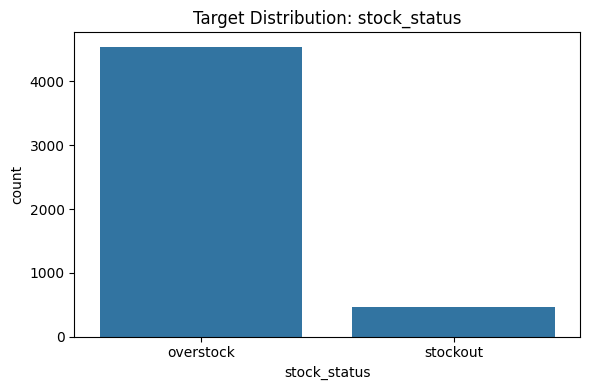

In [71]:
plt.figure(figsize=(6, 4))
sns.countplot(x='stock_status', data=df)
plt.title('Target Distribution: stock_status')
plt.tight_layout()
plt.show()

In [72]:
# --- FEATURE ENGINEERING ---
le = LabelEncoder()
for col in ['season', 'item_category', 'supplier_reliability', 'stock_status']:
    df[col] = le.fit_transform(df[col])

In [73]:
from sklearn.utils import resample

# Split majority and minority
majority_class = df['stock_status'].value_counts().idxmax()
minority_class = df['stock_status'].value_counts().idxmin()

df_majority = df[df['stock_status'] == majority_class]
df_minority = df[df['stock_status'] == minority_class]

# Upsample minority class
df_minority_upsampled = resample(df_minority,
                                 replace=True,
                                 n_samples=len(df_majority),
                                 random_state=42)

# Combine and shuffle
df_balanced = pd.concat([df_majority, df_minority_upsampled]).sample(frac=1, random_state=42)


In [74]:
X = df_balanced.drop('stock_status', axis=1)
y = df_balanced['stock_status']

In [75]:
# Select numeric features
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

In [76]:
# Calculate variance
variance = df[numeric_cols].var().sort_values(ascending=False)
print("Variance of numeric features:\n", variance)

Variance of numeric features:
 sales_last_30_days      87032.341159
current_stock            9929.681007
reorder_point            2516.708606
avg_daily_demand          102.098051
forecast_error             26.313149
lead_time_days              3.990472
stock_turnover_ratio        0.998809
item_category               0.250049
season                      0.250047
supplier_reliability        0.250042
stock_status                0.083063
dtype: float64


In [77]:
# Drop low-variance features (threshold = 0.01)
selector = VarianceThreshold(threshold=0.01)
selector.fit(df[numeric_cols])
variance_selected_cols = df[numeric_cols].columns[selector.get_support()].tolist()
print("\nFeatures selected based on variance:\n", variance_selected_cols)


Features selected based on variance:
 ['current_stock', 'avg_daily_demand', 'lead_time_days', 'reorder_point', 'sales_last_30_days', 'stock_turnover_ratio', 'forecast_error', 'season', 'item_category', 'supplier_reliability', 'stock_status']


In [78]:
# Encode target variable ('stock_status') for correlation
df_encoded = df.copy()
df_encoded['stock_status'] = df_encoded['stock_status'].astype('category').cat.codes

In [79]:
#  Add 'stock_status' to numeric columns for correlation
numeric_cols_with_target = numeric_cols.tolist()
if 'stock_status' not in numeric_cols_with_target:
    numeric_cols_with_target.append('stock_status')

In [80]:
#  Add 'stock_status' to numeric columns for correlation
numeric_cols_with_target = numeric_cols.tolist()
if 'stock_status' not in numeric_cols_with_target:
    numeric_cols_with_target.append('stock_status')

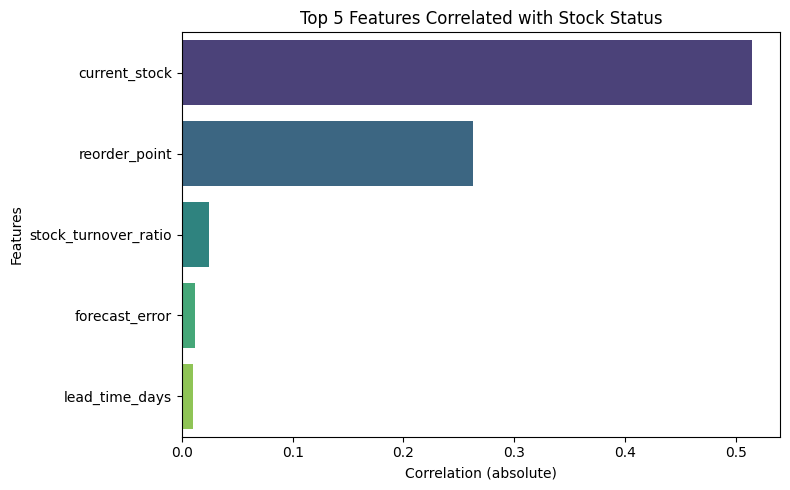

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate absolute correlations with 'stock_status'
correlations = df_encoded[numeric_cols_with_target].corr()['stock_status'].abs().sort_values(ascending=False)

# Get top 5 (excluding stock_status itself if it's included)
correlations = correlations.drop('stock_status', errors='ignore')  # ignore if not present
top_corr_features = correlations.head(5)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=top_corr_features.values, y=top_corr_features.index, palette='viridis')
plt.title('Top 5 Features Correlated with Stock Status')
plt.xlabel('Correlation (absolute)')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


In [82]:
final_selected_features = list(set(list(variance_selected_cols) + list(top_corr_features)))
print("\nFinal selected features for modeling:\n", final_selected_features)



Final selected features for modeling:
 ['season', 'stock_status', 'item_category', 'reorder_point', 'current_stock', 0.5142632414894043, 0.262459363849792, 0.02482513410769875, 'forecast_error', 0.00988009153712827, 'stock_turnover_ratio', 'lead_time_days', 'avg_daily_demand', 'sales_last_30_days', 'supplier_reliability', 0.012002995071527257]


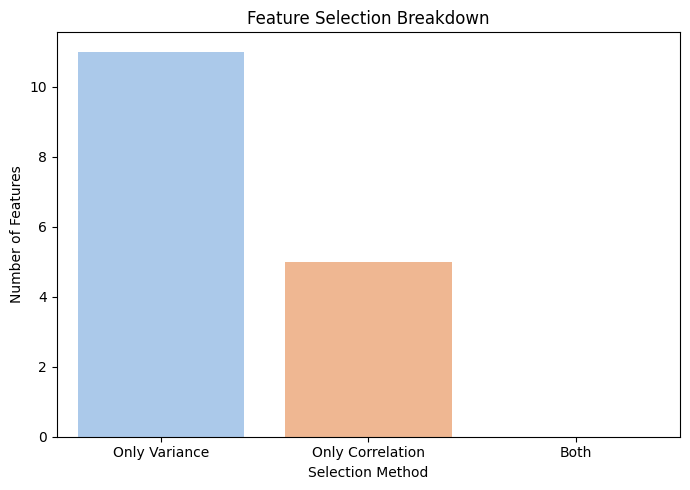

In [83]:
# Convert feature lists to sets
set_variance = set(variance_selected_cols)
set_corr = set(top_corr_features)

# Count categories
only_variance = len(set_variance - set_corr)
only_corr = len(set_corr - set_variance)
both = len(set_variance & set_corr)

# Bar plot
import seaborn as sns
import matplotlib.pyplot as plt

labels = ['Only Variance', 'Only Correlation', 'Both']
counts = [only_variance, only_corr, both]

plt.figure(figsize=(7, 5))
sns.barplot(x=labels, y=counts, palette='pastel')
plt.title('Feature Selection Breakdown')
plt.ylabel('Number of Features')
plt.xlabel('Selection Method')
plt.tight_layout()
plt.show()


In [84]:
# Ensure top_corr_features contains feature names
correlations = df_encoded[numeric_cols_with_target].corr()['stock_status'].abs().sort_values(ascending=False)
top_corr_features = correlations.drop('stock_status', errors='ignore').head(5).index.tolist()

# Merge with variance-selected features
final_selected_features = list(set(list(variance_selected_cols) + list(top_corr_features)))

# Now create final feature DataFrame
X_final = df[final_selected_features].copy()


In [85]:
# Display the shape and first few rows of the final engineered features
print("\nFinal feature dataset shape:", X_final.shape)
print(X_final.head())


Final feature dataset shape: (5000, 11)
   season  stock_status  item_category  reorder_point  current_stock  \
0       1             0              0         342.83            549   
1       1             0              1         348.37            486   
2       0             0              1         353.21            564   
3       0             0              0         397.34            652   
4       1             0              0         312.64            476   

   forecast_error  stock_turnover_ratio  lead_time_days  avg_daily_demand  \
0           -9.90                  4.17            5.64             45.76   
1           -5.27                  4.01            6.39             45.47   
2           -2.94                  3.57            5.81             32.04   
3            0.75                  4.00            7.22             46.70   
4            5.12                  4.49            9.39             57.33   

   sales_last_30_days  supplier_reliability  
0             160

In [86]:
print("DataFrame columns:", df.columns)

DataFrame columns: Index(['current_stock', 'avg_daily_demand', 'lead_time_days', 'reorder_point',
       'sales_last_30_days', 'stock_turnover_ratio', 'forecast_error',
       'season', 'item_category', 'supplier_reliability', 'stock_status'],
      dtype='object')


In [87]:
# 1️⃣ Distribution plots of engineered features
engineered_features = ['is_stockout', 'is_overstock', 'stock_to_demand_ratio', 'reorder_flag']

In [88]:
label_col = 'stock_status'

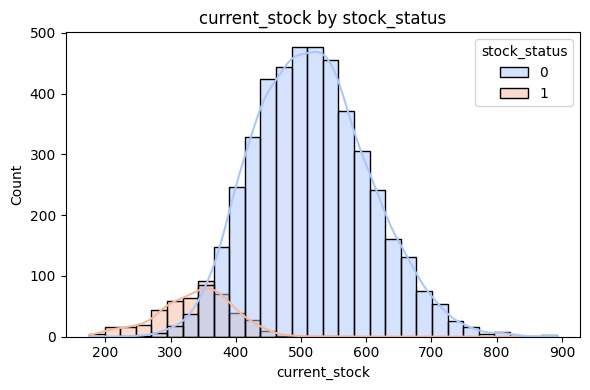

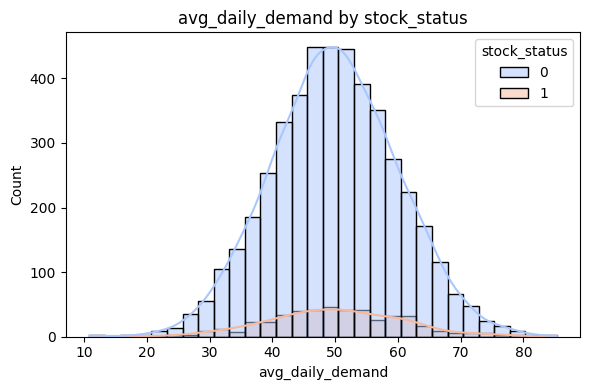

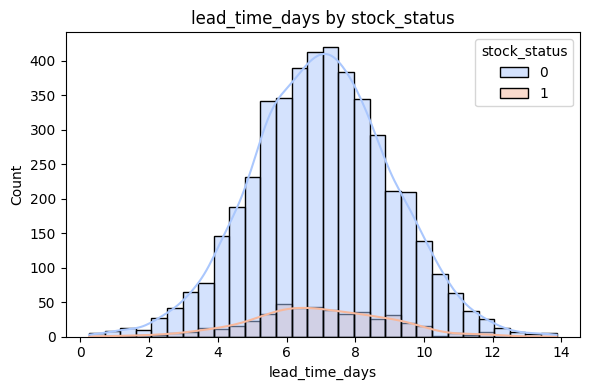

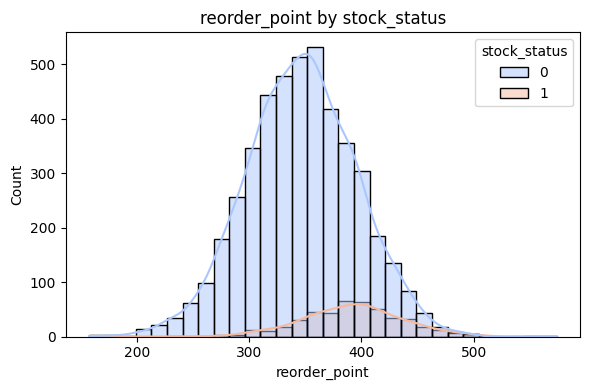

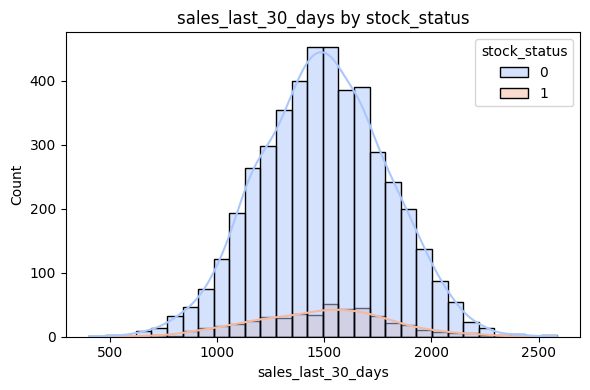

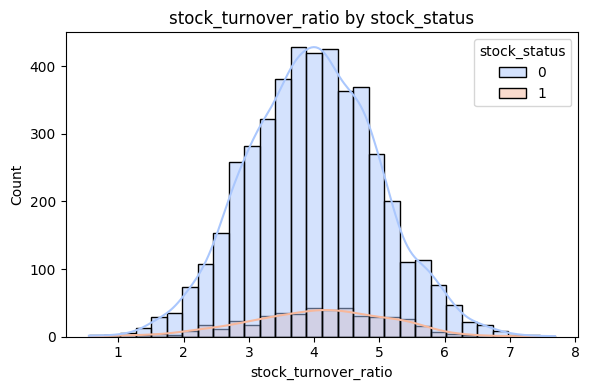

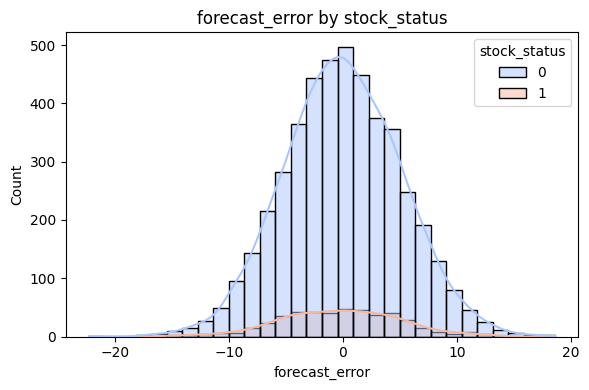

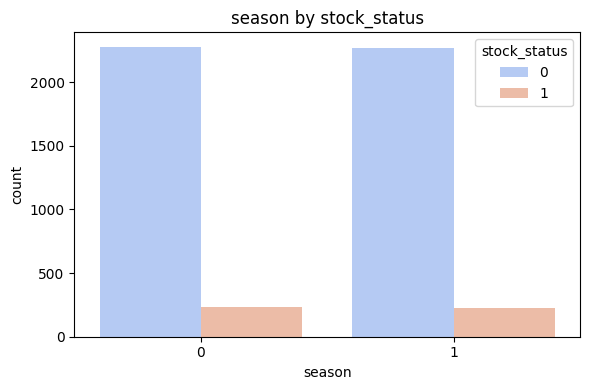

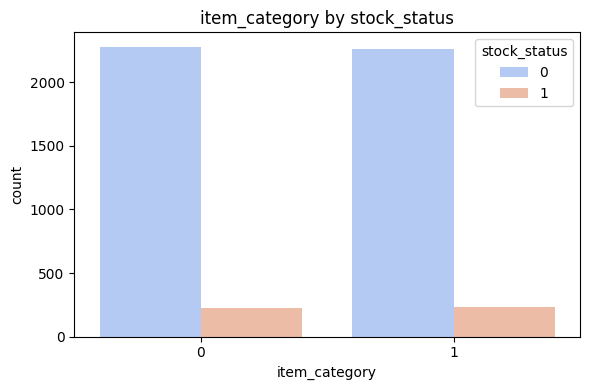

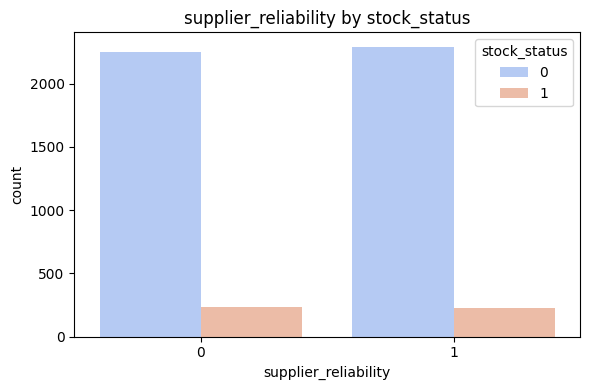

In [89]:
for feature in df.columns:
    if feature == label_col:
        continue

    plt.figure(figsize=(6, 4))

    if df[feature].nunique() <= 5:
        sns.countplot(data=df, x=feature, hue=label_col, palette='coolwarm')
    else:
        sns.histplot(data=df, x=feature, hue=label_col, kde=True, bins=30, palette='coolwarm')

    plt.title(f'{feature} by {label_col}')
    plt.tight_layout()
    plt.show()

In [90]:
# --- SCALING AND PCA ---
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

results = []


Logistic Regression
Accuracy: 0.987, Precision: 0.975, Recall: 1.000, F1 Score: 0.987


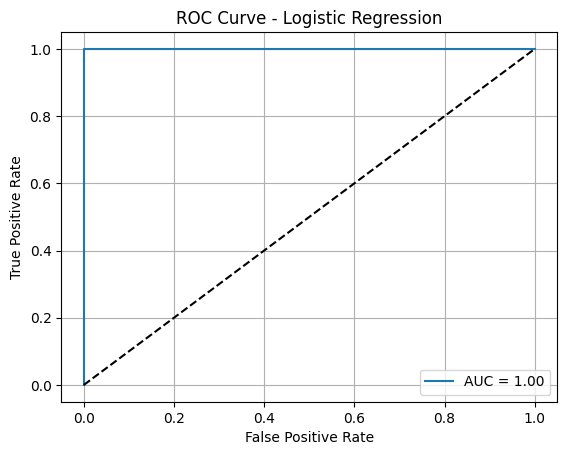

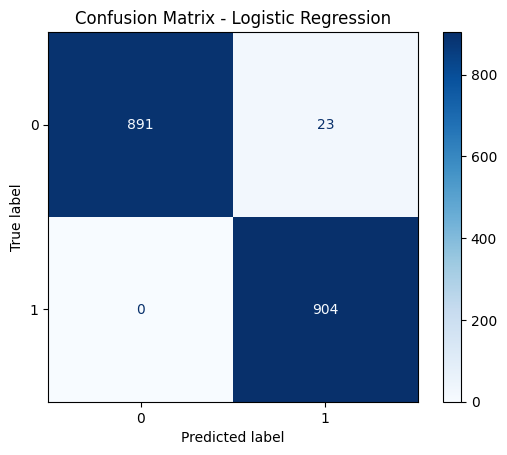

In [91]:
# --- LOGISTIC REGRESSION ---
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

print("\nLogistic Regression")
print(f"Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}, F1 Score: {f1:.3f}")
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve - Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.grid(False)
plt.show()

results.append({'Model': 'Logistic Regression', 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1 Score': f1})



Random Forest
Accuracy: 0.989, Precision: 0.978, Recall: 1.000, F1 Score: 0.989


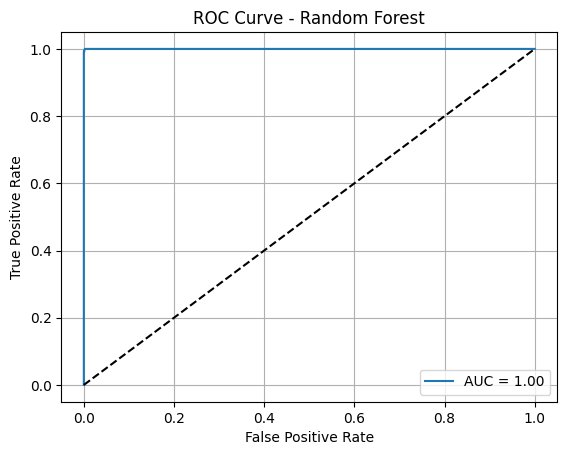

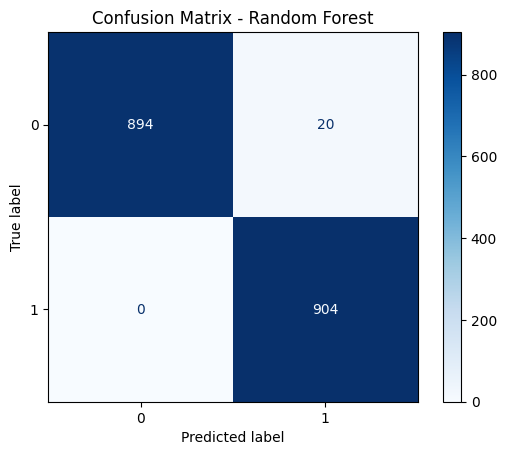

In [92]:
# --- RANDOM FOREST ---
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

print("\nRandom Forest")
print(f"Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}, F1 Score: {f1:.3f}")
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve - Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.grid(False)
plt.show()

results.append({'Model': 'Random Forest', 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1 Score': f1})


XGBoost
Accuracy: 0.988, Precision: 0.977, Recall: 1.000, F1 Score: 0.989


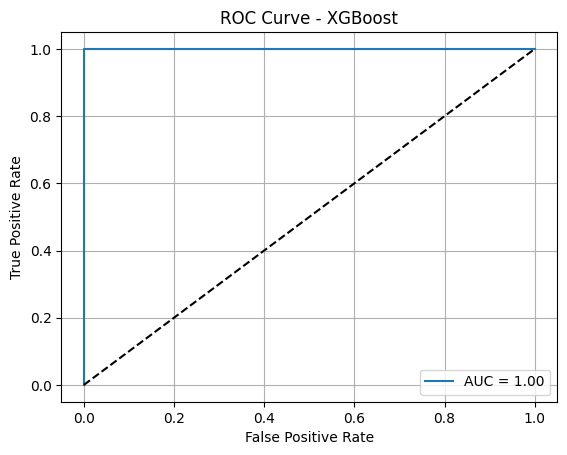

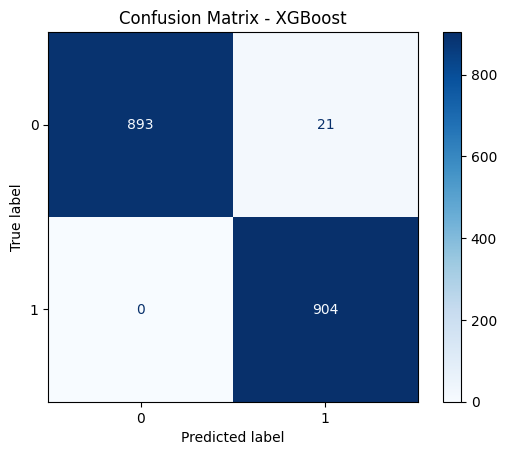

In [93]:
# --- XGBOOST ---
from xgboost import XGBClassifier

model = XGBClassifier(eval_metric='logloss')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

print("\nXGBoost")
print(f"Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}, F1 Score: {f1:.3f}")
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve - XGBoost")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - XGBoost")
plt.grid(False)
plt.show()

results.append({'Model': 'XGBoost', 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1 Score': f1})



SVM
Accuracy: 0.987, Precision: 0.974, Recall: 1.000, F1 Score: 0.987


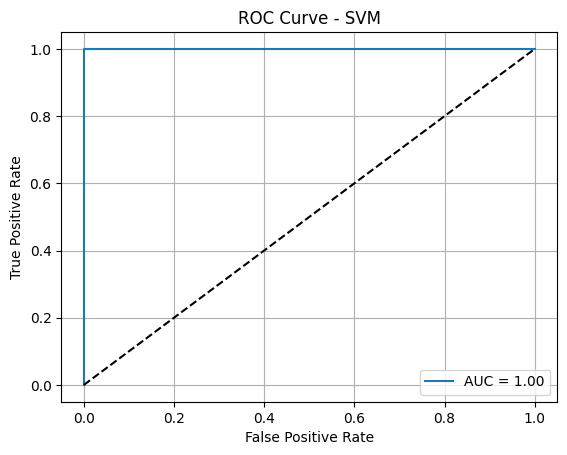

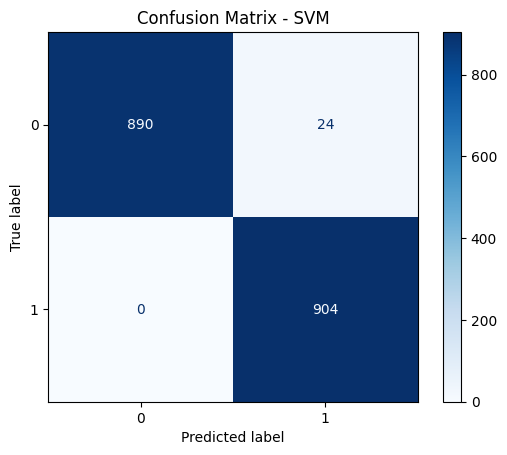

In [94]:
# --- SVM ---
from sklearn.svm import SVC

model = SVC(probability=True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

print("\nSVM")
print(f"Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}, F1 Score: {f1:.3f}")
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve - SVM")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - SVM")
plt.grid(False)
plt.show()

results.append({'Model': 'SVM', 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1 Score': f1})


KNN
Accuracy: 0.959, Precision: 0.926, Recall: 0.998, F1 Score: 0.961


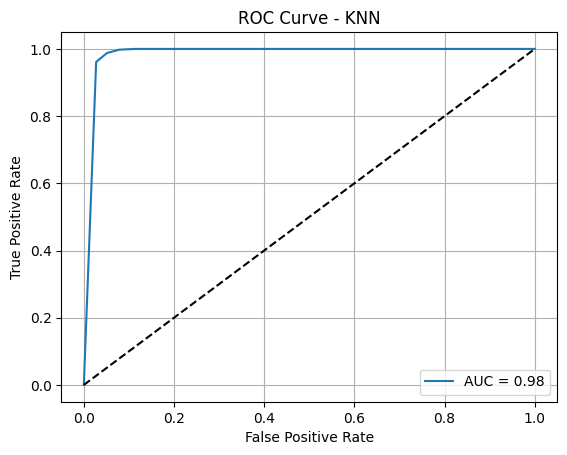

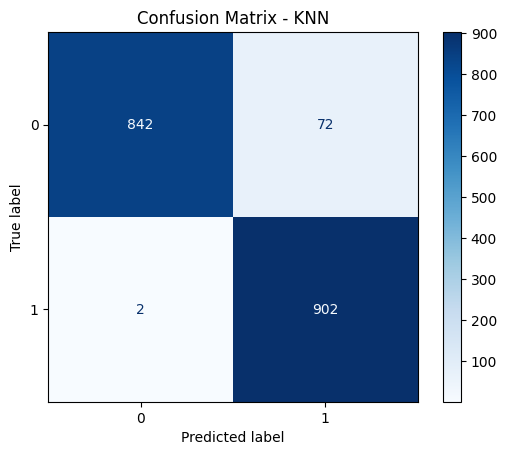

In [95]:
# --- KNN ---
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

print("\nKNN")
print(f"Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}, F1 Score: {f1:.3f}")
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve - KNN")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - KNN")
plt.grid(False)
plt.show()


results.append({'Model': 'KNN', 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1 Score': f1})


ANN (MLPClassifier)
Accuracy: 0.997, Precision: 0.994, Recall: 1.000, F1 Score: 0.997


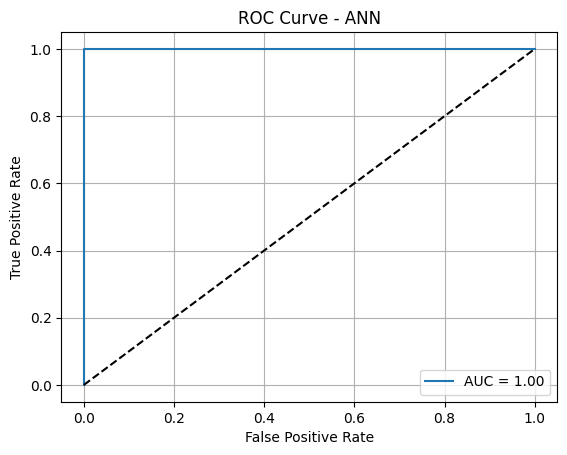

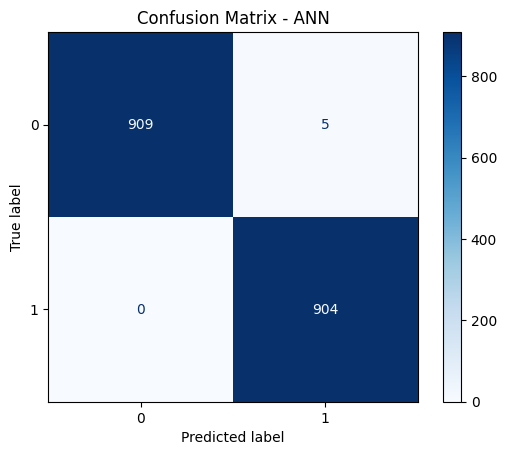

In [96]:
# --- ANN MODEL ---
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

print("\nANN (MLPClassifier)")
print(f"Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}, F1 Score: {f1:.3f}")
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve - ANN")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - ANN")
plt.grid(False)
plt.show()

results.append({'Model': 'ANN', 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1 Score': f1})


<Figure size 1200x600 with 0 Axes>

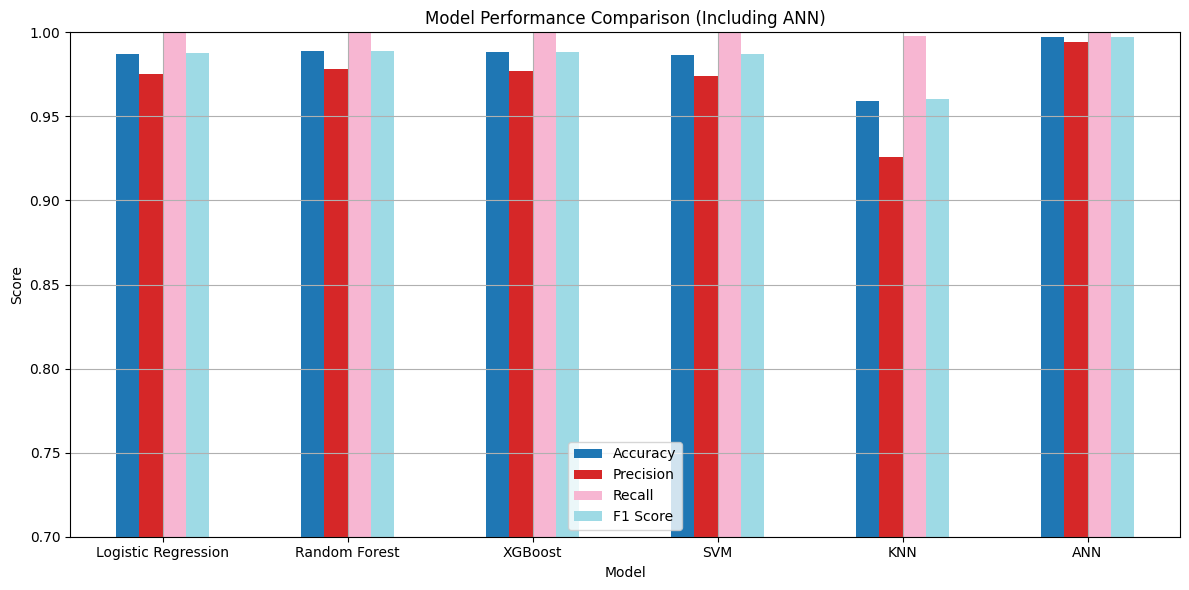

In [97]:
# --- BAR CHART COMPARISON ---
results_df = pd.DataFrame(results)
plt.figure(figsize=(12, 6))
bars = results_df.set_index('Model')[['Accuracy', 'Precision', 'Recall', 'F1 Score']]
bars.plot(kind='bar', figsize=(12, 6), colormap='tab20')
plt.title('Model Performance Comparison (Including ANN)')
plt.ylabel('Score')
plt.ylim(0.7, 1.0)
plt.grid(True)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# ANN is the High value and good performance